# Airline fatalities 1976-1985
We consider  the number of fatal accidents and deaths on scheduled airline flights per year over a ten-year period *Source: Gelman et al. 2014 Reproduced from Statistical Abstract of the United States.* 

Our goal is to create a model predicting such number in 1986.

In [1]:
import scipy.stats as stats
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from cmdstanpy import CmdStanModel

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [2]:
dts=[24,734,25,516,31,754,31,877,22,814,21,362,26,764,20,809,16,223,22,1066]
c1=dts[::2]
c2=dts[1::2]

Airline_data=pd.DataFrame({'Year':[1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
'Fatal accidents':c1,  
'Passenger deaths':c2,
'Death rate':[0.19,0.12,0.15,0.16,0.14,0.06,0.13,0.13,0.03,0.15]}).set_index('Year')
Airline_data['Miles flown [100 mln miles]']=np.round(Airline_data['Passenger deaths']/Airline_data['Death rate'])

## generation of vector for plotting samples under histograms
acc=[]
dta_cnt=[]
for k in Airline_data['Fatal accidents']:  
    dta_cnt.append(-(1.+acc.count(k)))
    acc.append(k)
dta_cnt=np.array(dta_cnt)

Airline_data

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


## Model for accidents
We start our modelling by proposing very simple model, with an assumption, that Fatal accidents number $y_i$ has a Poisson distribution 
$$y_i\sim\mathrm{Poisson}(\lambda)$$
with a rate $\lambda$ independent on year or miles flown.

### Prior for fatal accidents rate
We assume that having fatal accident every day would be very improbable. For poisson distribution we have mean of $\lambda$ and standard deviation of $\sqrt{\lambda}$. Approximately in order to have no more than 1% probability $\lambda$ should fulfill
$$\lambda+3\sqrt{\lambda}\approx365$$
We need to assign the prior that would have probability of smaller $\lambda$ equal 99%.

In [3]:
root_of_lam=np.polynomial.polynomial.polyroots([-365.,3.,1.])
lam_ub=np.round(root_of_lam[root_of_lam>0]**2)
print(lam_ub[0])



312.0


#### Prior tuning in Stan
Using Stan algebra solver we can solve nonlinear equations. In particular it can be used for finding distribution parameters that are fulfilling the conditions we have given. We can for example find $\sigma$ for a HalfNormal distribution.

In [4]:
with open('prior_tune3.stan', 'r') as file:
    print(file.read())

functions {
  // Difference between one-sided Gaussian tail probability and target probability
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[1] deltas;
    deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
    return deltas;
  }
}

data {
  vector[1] y_guess; // Initial guess of Gaussian standard deviation
  vector[1] theta;       // Target quantile
}

transformed data {

  vector[1] y;
  real x_r[0];
  int x_i[0];

  // Find Gaussian standard deviation that ensures 99% probabilty below 15
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);

  print("Standard deviation = ", exp(y[1]));
}

generated quantities {
  real sigma = exp(y[1]);
}



In [5]:
tuning2=CmdStanModel(stan_file='prior_tune3.stan')


INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpaa57chhs/tmp3268tbji
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 3 - One parameter models/Single parameters models/Flight data/prior_tune3


In [6]:
data=dict(y_guess=np.array([np.log(100)]),theta=np.array(lam_ub))
tuned2 = tuning2.sample(data=data,
                          seed=1052020,
                          fixed_param=True,
                          iter_sampling=1, 
                          iter_warmup=0,
                          chains=1)
sigma = np.round(tuned2.stan_variable('sigma')[0])
print(sigma)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
121.0


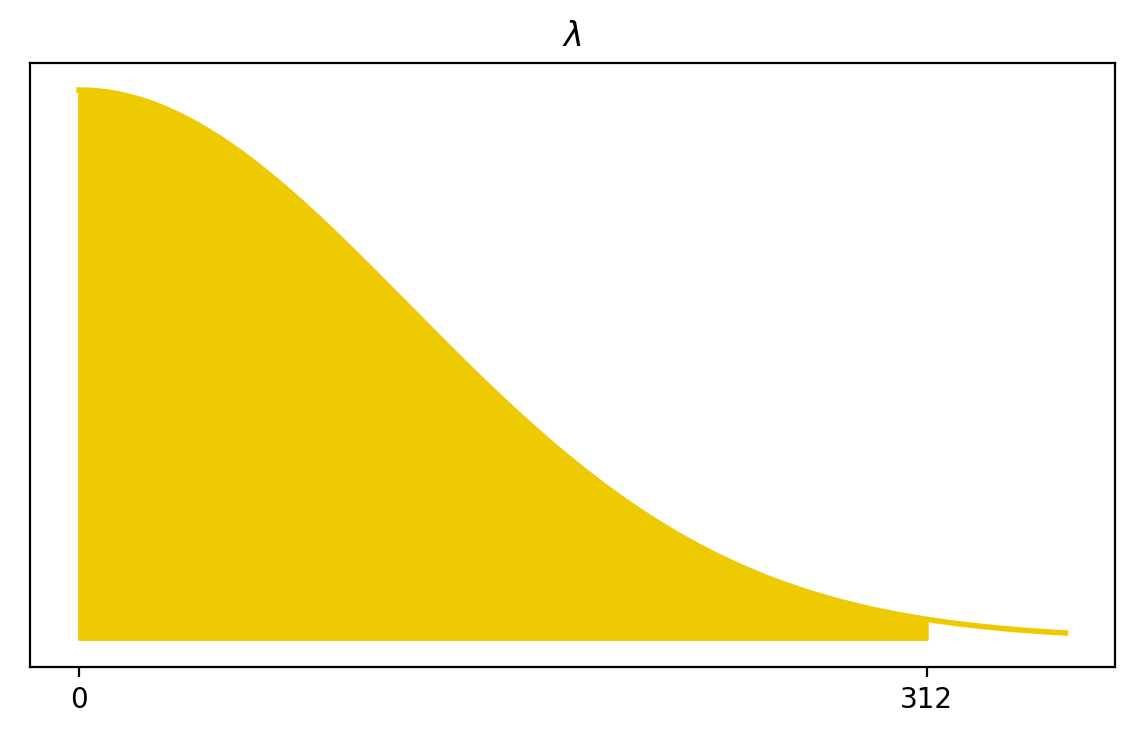

In [7]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,lam_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),color=dark,linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0,color=dark)
ax2.set_yticks([])
ax2.set_xticks([0,lam_ub[0]])
ax2.set_title(r'$\lambda$')
plt.show()

### Prior predictive distribution
We can use stan to simulate possible outputs and parameteres based only on prior information.

In [8]:
with open('airline_FA_hnorm_ppc.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
}


generated quantities {
  real lambda=fabs(normal_rng(0,121));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}



In [9]:
model_prior=CmdStanModel(stan_file='airline_FA_hnorm_ppc.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp9uaxx_j7/tmp43e_aup8
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 3 - One parameter models/Single parameters models/Flight data/airline_FA_hnorm_ppc


In [10]:
R=1000
sim_uf=model_prior.sample(data={'M':1},
                            fixed_param=True,
                            iter_sampling=R,
                            iter_warmup=0,
                            chains=1, 
                            refresh=R,
                            seed=29042020)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


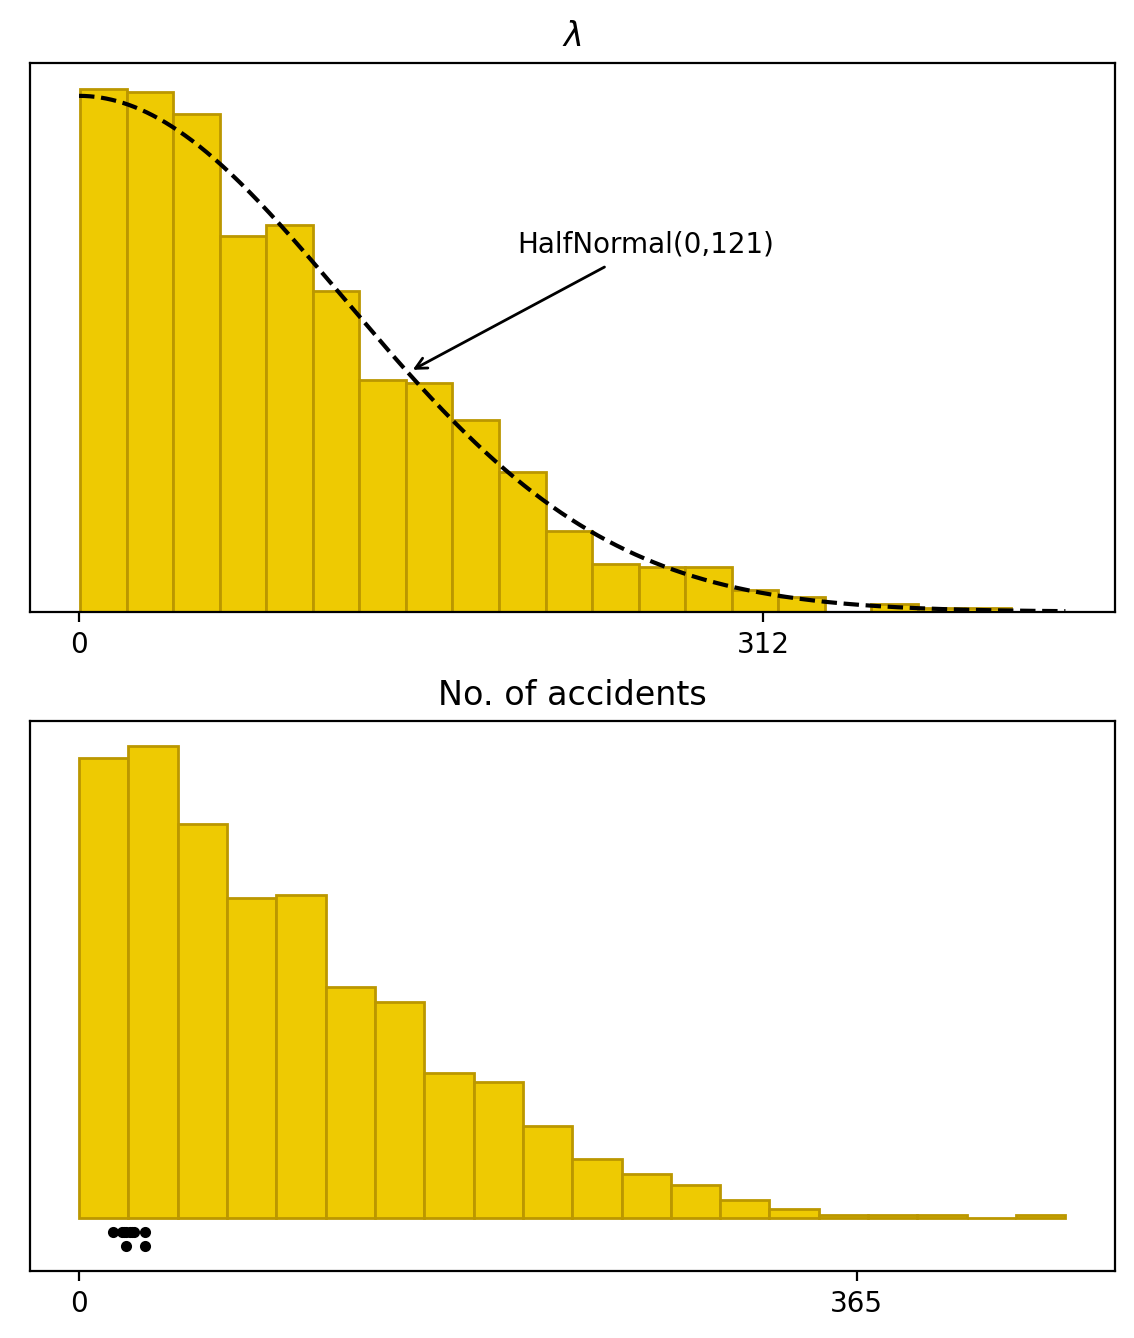

In [11]:
theta=sim_uf.stan_variable('lambda')
y_sim=sim_uf.stan_variable('y_sim')

fig, axes = plt.subplots(2, 1,figsize=(7, 8))
ax1=axes[0]
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,450,2000)
ax1.set_xticks([0,lam_ub[0]])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(150,0,sigma)
ax1.annotate('HalfNormal(0,'+str(int(sigma))+')',xy=(150,arr_y_loc),xytext=(200,1.5*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax2=axes[1]
ax2.hist(y_sim.flatten(),color=dark,edgecolor=dark_highlight,density=True,bins=20,zorder=1)
ax2.scatter(acc,0.0002*dta_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([0,365])
ax2.set_yticks([])

ax2.set_title('No. of accidents')
plt.show()

## Posterior inference and posterior predictive checks

In [12]:
with open('airline_FA_hnorm_fit.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
  int y[M];//number of fatal accidents
}
parameters {
  real<lower=0>lambda;
}
model {
  lambda ~ normal(0,121);
  for (k in 1:M) {
    y[k] ~ poisson(lambda);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}



In [13]:
model=CmdStanModel(stan_file='airline_FA_hnorm_fit.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp68cqnyih/tmpacysost5
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 3 - One parameter models/Single parameters models/Flight data/airline_FA_hnorm_fit


In [14]:
data = dict(M = len(Airline_data),
            y = Airline_data['Fatal accidents'].values)
fit = model.sample(data=data, seed=8052020)

lam=fit.stan_variable('lambda')
y_sim=fit.stan_variable('y_sim')


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3


In [15]:
mean_lam = np.mean(lam)
cinf_lam = az.hdi(lam,0.89)

hpd_width=cinf_lam[1]-cinf_lam[0]

In [16]:
print('Mean lambda : {:4.2f}'.format(mean_lam))
print('89% confidence interval: [',*['{:4.2f}'.format(k) for k in cinf_lam],']')

Mean lambda : 23.90
89% confidence interval: [ 21.48 26.46 ]


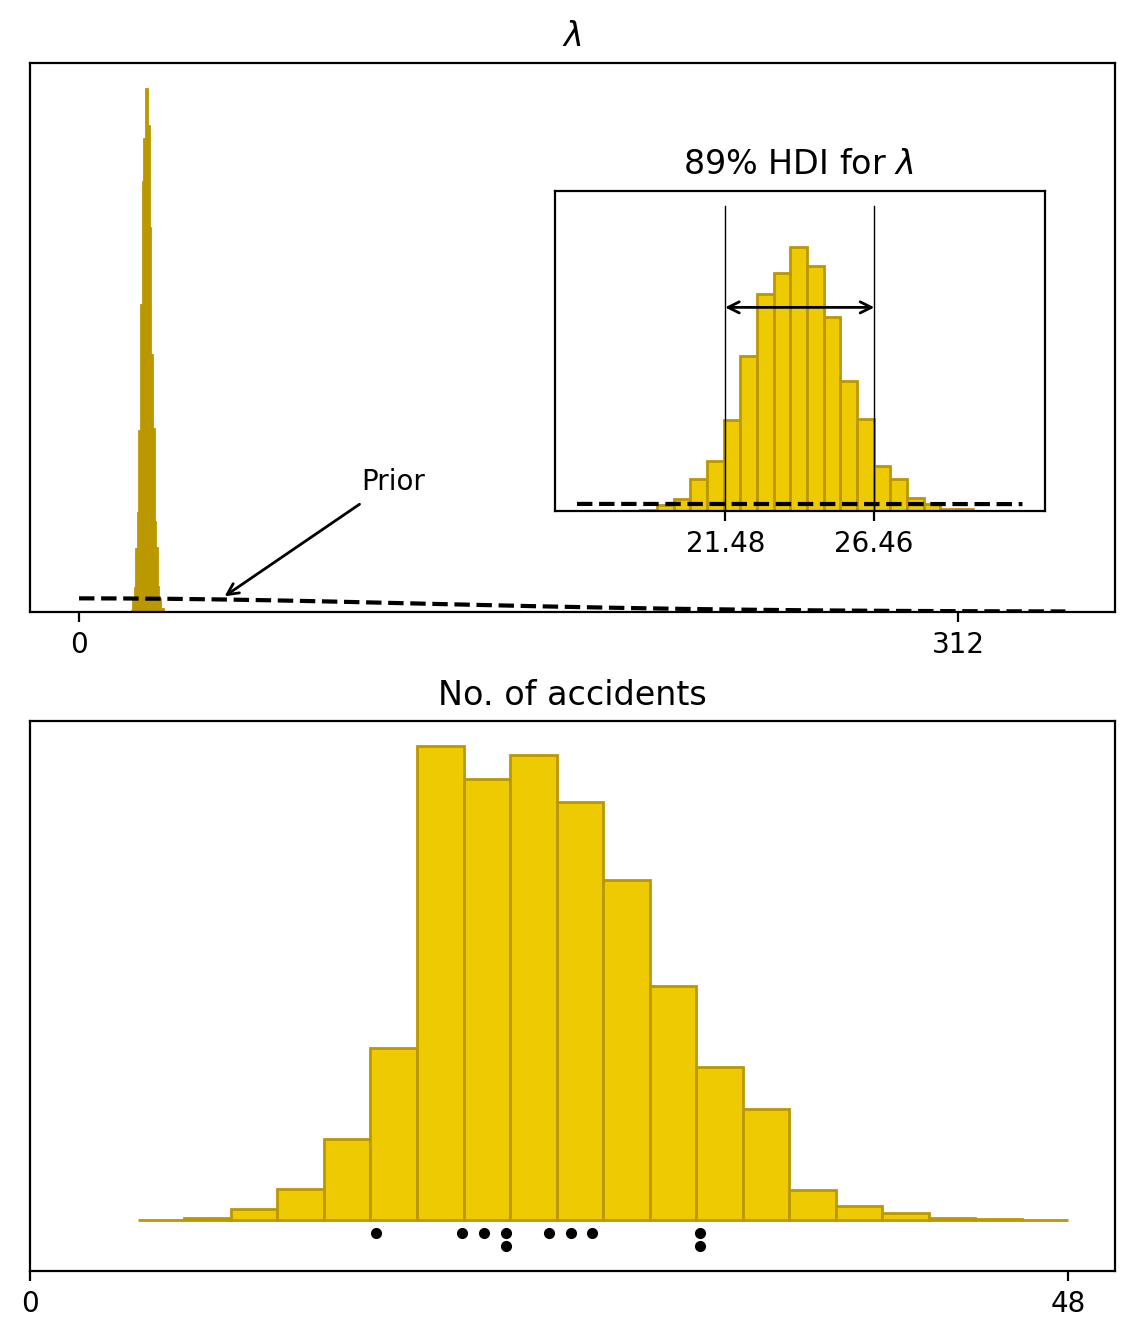

In [17]:


    
fig, axes = plt.subplots(2, 1,figsize=(7, 8))
ax1=axes[0]
ax1.hist(lam,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,350,1000)
#ax1.plot(x,2*stats.t.pdf(x,5,0,10),color='black',linestyle='--')

ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(50,0,sigma)
ax1.annotate('Prior',xy=(50,arr_y_loc),xytext=(100,10*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax1.set_xticks([0,lam_ub[0]])

ax1.set_yticks([])
ax1.set_title(r'$\lambda$')

ax_sm=plt.axes([0.5,0.6,0.35,0.2])
x_sm=np.linspace(cinf_lam[0]-hpd_width,cinf_lam[1]+hpd_width,200)
ax_sm.hist(lam,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')
ax_sm.annotate(text='', xy=(cinf_lam[0]-.2,0.2), xytext=(cinf_lam[1]+.2,0.2), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_lam[0],cinf_lam[0]],[0,0.3],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_lam[1],cinf_lam[1]],[0,0.3],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(np.round([cinf_lam[0],cinf_lam[1]],2))
ax_sm.set_yticks([])
ax_sm.set_title(r'89% HDI for $\lambda$ ')


ax2=axes[1]
ax2.hist(y_sim.flatten(),color=dark,edgecolor=dark_highlight,density=True,bins=20,zorder=1)
ax2.scatter(acc,0.002*dta_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([0,np.max(y_sim)])
ax2.set_yticks([])

ax2.set_title('No. of accidents')
plt.show()

### Using model for prediction

In 1986, there were **22** fatal accidents, **546** passenger deaths, and a death rate of **0.06** per 100 million miles flown. Lets check how our can perform such prediction.

In order to predict value in 1986 we just need to use the prior predictive distribution of y_sim.

In [18]:
median_y_sim = np.median(y_sim.flatten())
cinf_y_sim = az.hdi(y_sim.flatten(),0.89)

print('Median of predicted accidents =',median_y_sim)
print('Confidence interval = [',*cinf_y_sim,']')



Median of predicted accidents = 24.0
Confidence interval = [ 15.0 31.0 ]


## Modelling for accidents, considering miles

It is rather logical, that number of accidents should be related to number of miles flown. We can still use the Poisson model, however we can decompose rate $\lambda$ into intensity $\theta$ and exposure $n$, i.e.

$$y_i\sim\mathrm{Poisson}(\theta n)$$
With $n$ being a number miles flown (in 100 mil)
.

### Prior for fatal accidents intensity
We still assume that having fatal accident every day would be very improbable. Our previous argument, can be still valid, however in order to compute the bound we will use $\lambda=\theta\cdot\bar{n}$, with $\bar{n}$ being mean of miles flown. This gives us condition

$$\theta\cdot\bar{n}+3\sqrt{\theta\cdot\bar{n}}\approx365$$

We need to assign the prior for $\theta$ that would have probability of smaller $\lambda$ equal 99%.

In [19]:
mean_miles=np.mean(Airline_data['Miles flown [100 mln miles]'])
root_of_theta=np.polynomial.polynomial.polyroots([-365/mean_miles,3./np.sqrt(mean_miles),1.])
theta_ub=(root_of_theta[root_of_lam>0]**2)
print('theta upper bound','{:4.3f}'.format(theta_ub[0]))



theta upper bound 0.055


In [20]:
data=dict(y_guess=np.array([np.log(0.01)]),theta=np.array(theta_ub))
tuned2 = tuning2.sample(data=data,
                          seed=1052020,
                          fixed_param=True,
                          iter_sampling=1, 
                          iter_warmup=0,
                          chains=1)
sigma = (tuned2.stan_variable('sigma')[0])
print('sigma =','{:4.3f}'.format(sigma))

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
sigma = 0.021


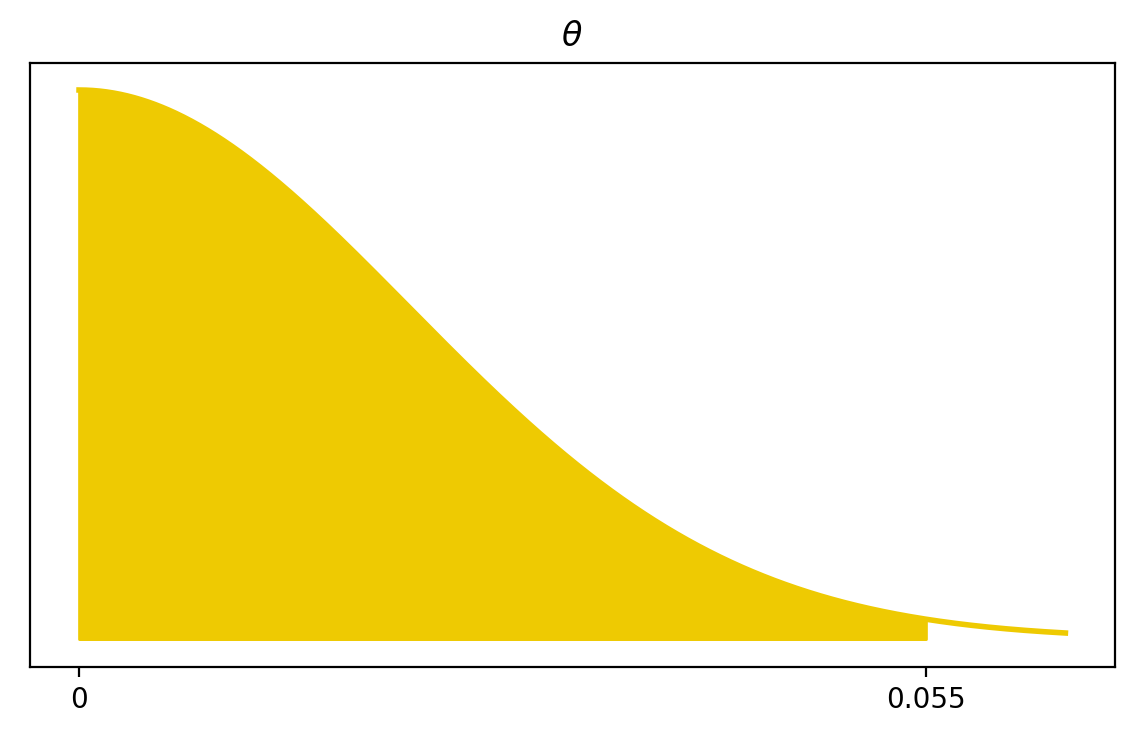

In [21]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,theta_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),color=dark,linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0,color=dark)
ax2.set_yticks([])
ax2.set_xticks([0,theta_ub[0]])
ax2.set_xticklabels([0,0.055])
ax2.set_title(r'$\theta$')
plt.show()

### Prior predictive distribution
We can use Stan to simulate possible outputs and parameteres based only on prior information.

In [22]:
with open('airline_FA_miles_hnorm_ppc.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
  vector[M] miles; //number of miles flown each year
}


generated quantities {
  real theta=fabs(normal_rng(0,0.021));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(theta*miles[k]);
  }
}



In [23]:
model_prior=CmdStanModel(stan_file='airline_FA_miles_hnorm_ppc.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp0wgzmrvt/tmp0k8y7j4c
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 3 - One parameter models/Single parameters models/Flight data/airline_FA_miles_hnorm_ppc


In [24]:
R=1000
data_prior=dict(M=len(Airline_data),miles=Airline_data['Miles flown [100 mln miles]'].to_numpy())
sim_uf=model_prior.sample(data=data_prior,
                        fixed_param=True, 
                        iter_sampling=R, 
                        iter_warmup=0, 
                        chains=1, 
                        refresh=R,
                        seed=29042020)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


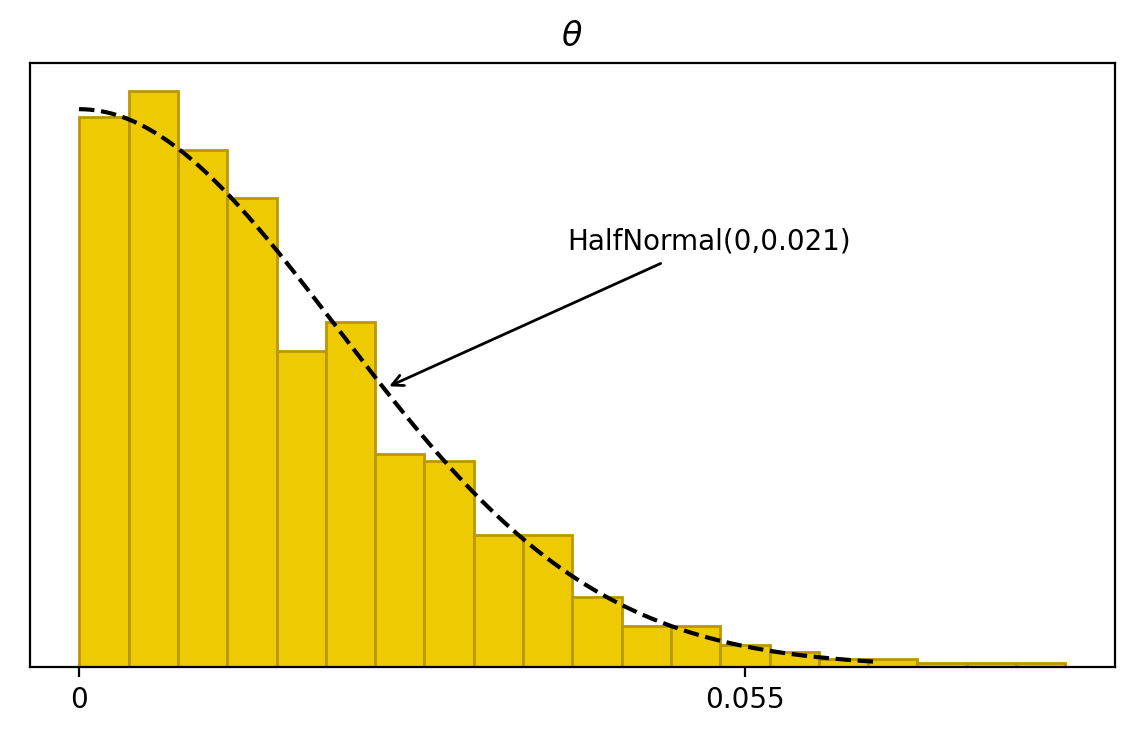

In [25]:
theta=sim_uf.stan_variable('theta')

fig, axes = plt.subplots(1, 1,figsize=(7, 4))
ax1=axes
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(0.025,0,sigma)
ax1.annotate('HalfNormal(0,'+'{:4.3f}'.format(sigma)+')',xy=(0.025,arr_y_loc),xytext=(0.04,1.5*arr_y_loc),arrowprops={'arrowstyle':'->'})
plt.show()

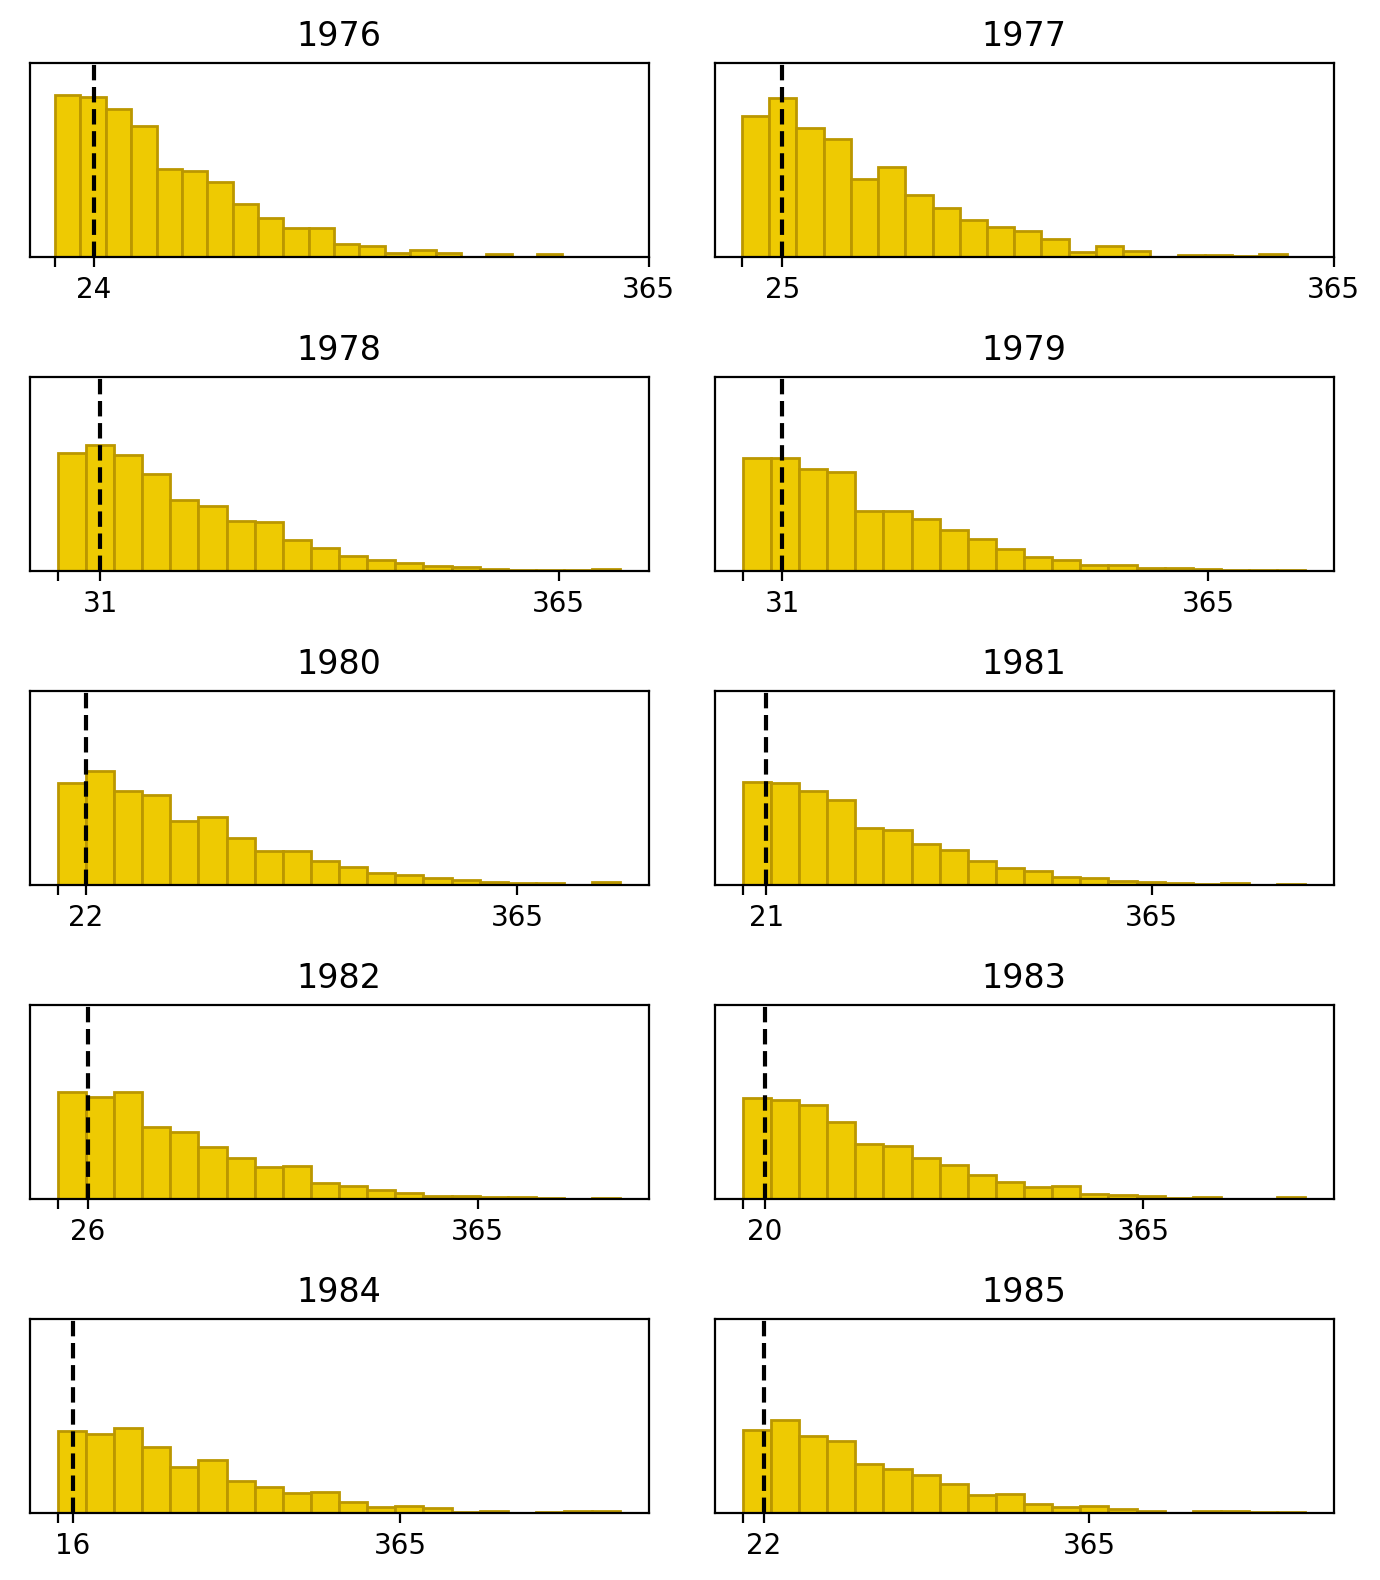

In [26]:
y_sim=sim_uf.stan_variable('y_sim')
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,color=dark,edgecolor=dark_highlight,density=True)
    ax.set_title(Airline_data.index[k])
    tv=Airline_data['Fatal accidents'].iloc[k]
    ax.plot([tv,tv],[0,0.02],linestyle='--',color='black')
    ax.set_yticks([])
    ax.set_xticks([0,tv,365])
    ax.set_xticklabels(['',tv,365])
    ax.set_ylim([0,0.012])

fig.tight_layout()

plt.show()

## Posterior inference and posterior predictive checks

In [27]:
with open('airline_FA_miles_hnorm_fit.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
  vector[M] miles; //number of miles flown each year
  int y[M];//number of fatal accidents
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0,0.021);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(miles[k]*theta);
  }
}



In [28]:
model_miles=CmdStanModel(stan_file='airline_FA_miles_hnorm_fit.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmplp5ejbv9/tmpqsrya0y0
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 3 - One parameter models/Single parameters models/Flight data/airline_FA_miles_hnorm_fit


In [29]:
data = dict(M = len(Airline_data),
            miles = Airline_data['Miles flown [100 mln miles]'].values,
            y = Airline_data['Fatal accidents'].values)
fit = model_miles.sample(data=data, seed=8052020)

theta=fit.stan_variable('theta')
y_sim=fit.stan_variable('y_sim')


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [30]:
mean_theta = np.mean(theta)
cinf_theta = az.hdi(theta,0.89)
hpd_width=cinf_theta[1]-cinf_theta[0]

In [31]:
print('Mean theta : {:5.4f}'.format(mean_theta))
print('89% confidence interval: [',*['{:5.4f}'.format(k) for k in cinf_theta],']')

Mean theta : 0.0042
89% confidence interval: [ 0.0037 0.0046 ]


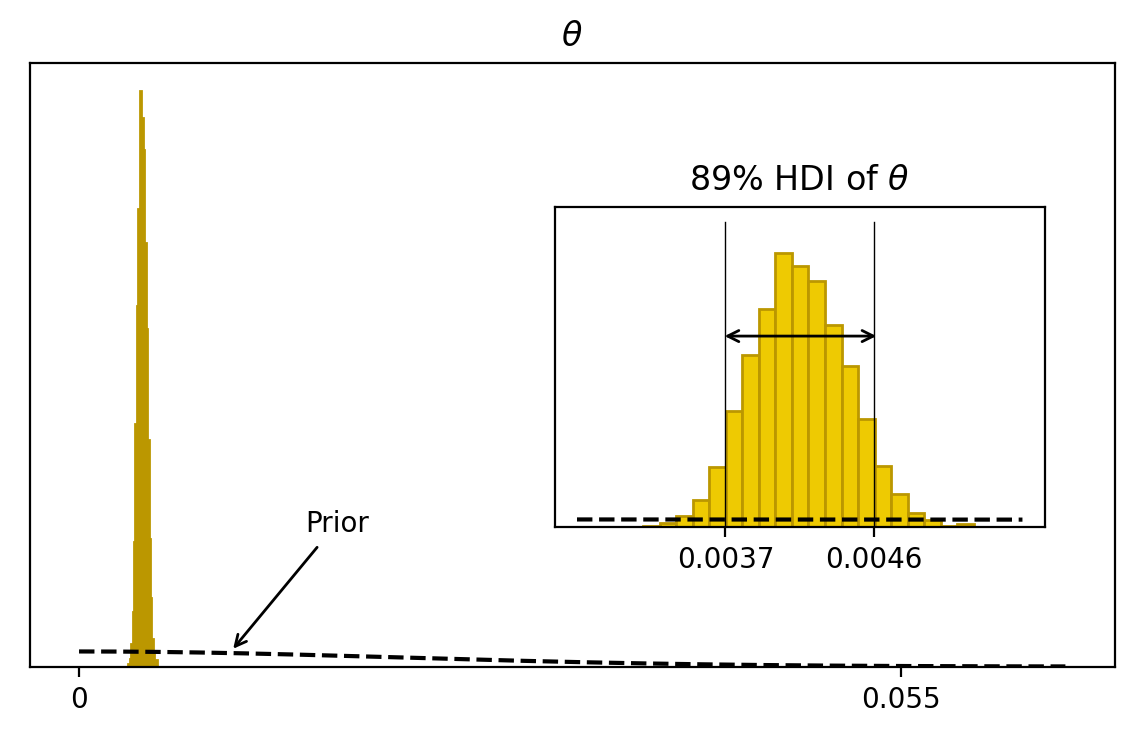

In [32]:
    
#fig, axes = plt.subplots(2, 1,figsize=(7, 8))

fig, axes = plt.subplots(1, 1,figsize=(7, 4))
ax1=axes
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(0.01,0,sigma)
ax1.annotate('Prior',xy=(0.01,arr_y_loc),xytext=(0.015,10*arr_y_loc),arrowprops={'arrowstyle':'->'})

ax_sm=plt.axes([0.5,0.3,0.35,0.4])
x_sm=np.linspace(cinf_theta[0]-hpd_width,cinf_theta[1]+hpd_width,200)
ax_sm.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')
ax_sm.annotate(text='', xy=(0.99*cinf_theta[0],1000), xytext=(1.01*cinf_theta[1],1000), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_theta[0],cinf_theta[0]],[0,1600],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_theta[1],cinf_theta[1]],[0,1600],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(([cinf_theta[0],cinf_theta[1]]))
ax_sm.set_xticklabels(np.round([cinf_theta[0],cinf_theta[1]],4))

ax_sm.set_yticks([])
ax_sm.set_title(r'89% HDI of $\theta$')

plt.show()

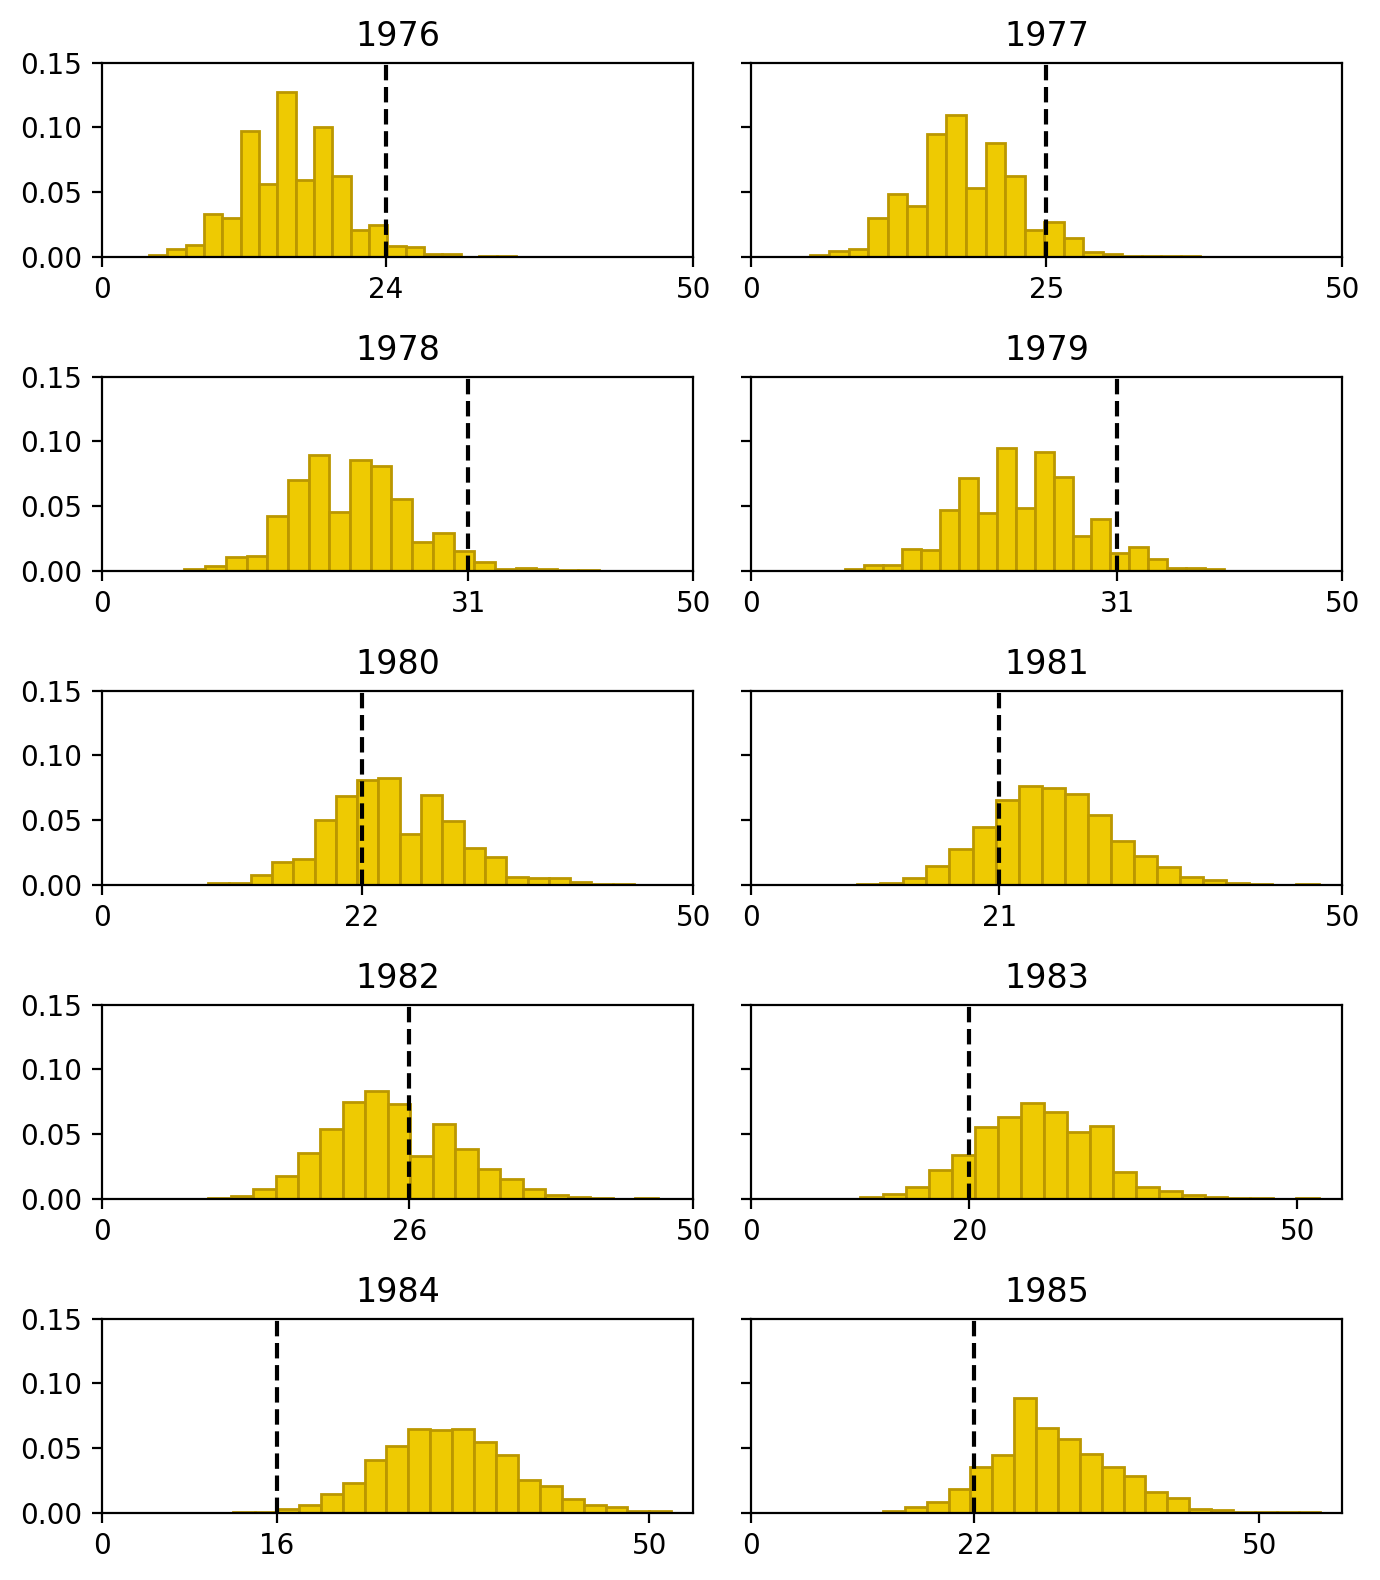

In [33]:
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,color=dark,edgecolor=dark_highlight,density=True)
    ax.set_title(Airline_data.index[k])
    tv=Airline_data['Fatal accidents'].iloc[k]
    ax.plot([tv,tv],[0,0.15],linestyle='--',color='black')
    #ax.set_yticks([])
    ax.set_xticks([0,tv,50])
    ax.set_xticklabels([0,tv,50])
    ax.set_ylim([0,0.15])

fig.tight_layout()

plt.show()

### Using model for prediction

In this situation prediction might be a slight more complicated, as it requires from us modifying the generated quantities block.
As stated before in 1986, there were **22** fatal accidents, **546** passenger deaths, and a death rate of **0.06** per 100 million miles flown. 

In [34]:
miles1986=546/0.06
print(np.round(miles1986))

9100.0


In [35]:
with open('airline_FA_miles_1986.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
  vector[M] miles; //number of miles flown each year
  int y[M];//number of fatal accidents
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0,0.021);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_1986 = poisson_rng(9100*theta);
}



In [36]:
model1986=CmdStanModel(stan_file='airline_FA_miles_1986.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpa6ect5zq/tmpcmfrgtt6
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 3 - One parameter models/Single parameters models/Flight data/airline_FA_miles_1986


In [37]:
data = dict(M = len(Airline_data),
            miles = Airline_data['Miles flown [100 mln miles]'].values,
            y = Airline_data['Fatal accidents'].values)
fit1986 = model1986.sample(data=data, seed=8052020)

y_1986=fit1986.stan_variable('y_1986')

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1


In [38]:
median_y_1986 = np.median(y_1986)
cinf_y_1986 = az.hdi(y_1986,0.89)

print('Median of predicted accidents =',median_y_1986)
print('Confidence interval = [',*cinf_y_1986,']')



Median of predicted accidents = 38.0
Confidence interval = [ 26.0 47.0 ]


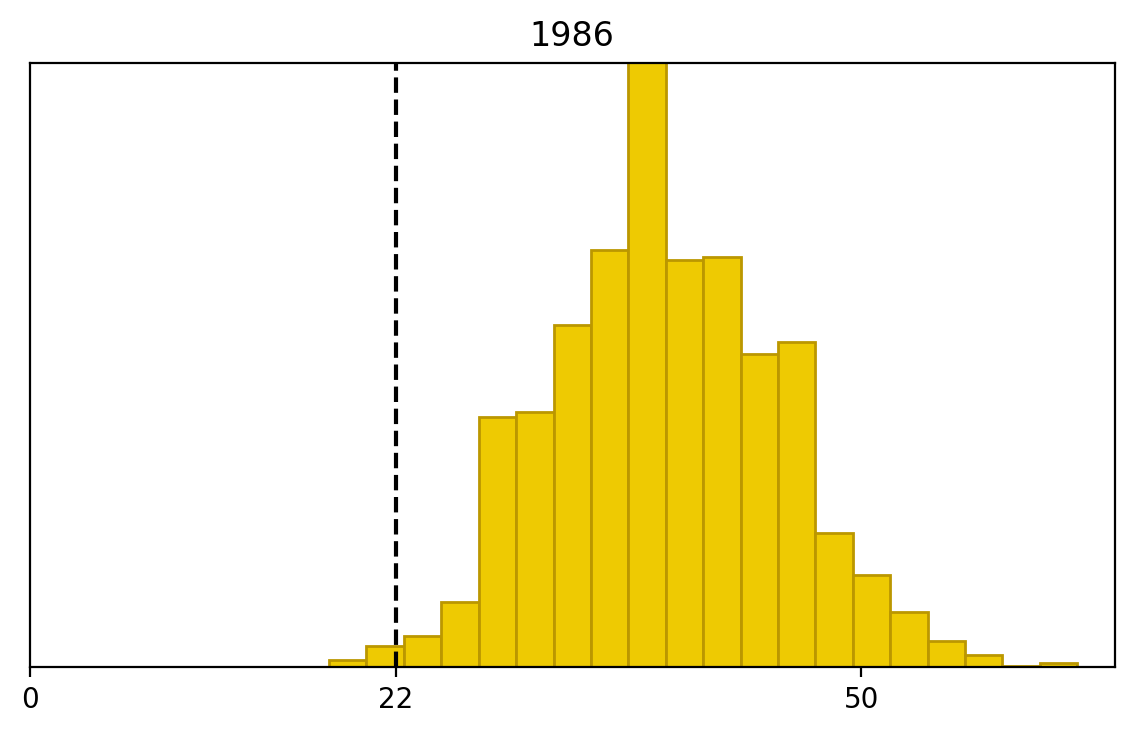

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(y_1986,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax.set_title('1986')
tv = 22
ax.plot([tv,tv],[0,0.07],linestyle='--',color='black')
ax.set_yticks([])
ax.set_xticks([0,tv,50])
ax.set_xticklabels(['0',tv,50])
ax.set_ylim([0,0.07])


plt.show()